<a href="https://colab.research.google.com/github/Shuvam1024/BcellEpitope/blob/main/BcellEpitope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
 

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
# !pip install --upgrade tensorflow

# For the latest nightly build:
# !pip install tf-nightly

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Name: tensorflow
Version: 2.8.2+zzzcolab20220719082949
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: termcolor, wrapt, tensorflow-estimator, keras, gast, absl-py, protobuf, astunparse, libclang, opt-einsum, numpy, h5py, keras-preprocessing, flatbuffers, typing-extensions, google-pasta, setuptools, grpcio, tensorflow-io-gcs-filesystem, six, tensorboard
Required-by: kapre


In [3]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
# print(tf.__version__)

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 500
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
# np.set_printoptions(linewidth = 200)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [8]:
#!ls gdrive/"My Drive"/"Colab Notebooks"
# data_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/input_bcell.csv", sep=",")
data1_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/input_bcell.csv", sep=",")
data2_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/input_sars.csv", sep=",")
data_df = pd.concat([data1_df, data2_df], ignore_index=True)
data_df = data_df.reindex(np.random.permutation(data_df.index)) # shuffle the examples
data_df.describe()

#data_df_num.corr()


,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
count,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0
mean,308.8,319.5,1.0,1.1,1.0,1.8,7.0,0.1,-0.4,43.3,0.3
std,358.4,358.6,0.1,1.8,0.1,2.0,1.9,0.0,0.4,16.5,0.4
min,1.0,6.0,0.5,0.0,0.8,-9.0,3.7,0.0,-2.0,5.4,0.0
25%,86.0,96.0,0.9,0.2,1.0,0.6,5.6,0.1,-0.6,31.7,0.0
50%,197.0,208.0,1.0,0.6,1.0,1.8,6.4,0.1,-0.3,41.9,0.0
75%,400.0,411.0,1.1,1.2,1.1,3.0,8.7,0.1,-0.2,49.1,1.0
max,3079.0,3086.0,1.5,40.6,1.3,9.1,12.2,0.2,1.3,137.0,1.0


In [9]:
#@title Add synthetic features

def add_synthetic_features(data):
  data["peptide_length"] = data["end_position"] - data["start_position"] + 1
  data["hs_ratio"] = data["hydrophobicity"] / data["stability"]
  return data

data_df = add_synthetic_features(data_df)
# Examine correlations
data_df.corr()

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,peptide_length,hs_ratio
start_position,1.0,1.0,0.0,0.0,-0.0,-0.0,-0.3,0.3,0.0,-0.1,-0.1,0.0,-0.0
end_position,1.0,1.0,0.0,0.0,-0.0,-0.0,-0.3,0.3,0.0,-0.1,-0.1,0.0,-0.0
chou_fasman,0.0,0.0,1.0,0.2,-0.4,0.6,0.0,0.0,-0.1,0.1,0.1,0.0,-0.1
emini,0.0,0.0,0.2,1.0,-0.4,0.4,-0.0,0.0,0.0,-0.0,0.1,0.1,0.0
kolaskar_tongaonkar,-0.0,-0.0,-0.4,-0.4,1.0,-0.7,-0.0,0.1,0.3,-0.0,-0.0,0.0,0.2
parker,-0.0,-0.0,0.6,0.4,-0.7,1.0,-0.0,-0.2,-0.3,0.1,0.0,-0.0,-0.2
isoelectric_point,-0.3,-0.3,0.0,-0.0,-0.0,-0.0,1.0,-0.2,-0.2,0.2,-0.1,-0.1,-0.2
aromaticity,0.3,0.3,0.0,0.0,0.1,-0.2,-0.2,1.0,0.3,-0.3,0.0,0.2,0.2
hydrophobicity,0.0,0.0,-0.1,0.0,0.3,-0.3,-0.2,0.3,1.0,-0.4,0.1,0.1,0.8
stability,-0.1,-0.1,0.1,-0.0,-0.0,0.1,0.2,-0.3,-0.4,1.0,0.0,-0.0,0.0


In [10]:
#@title Augment data

def convert_raw_to_zscores(data):
  # Calculate the Z-scores of each column in the data set:
  data_mean = data.mean()
  data_std = data.std()
  data_norm = (data - data_mean)/data_std
  return data_norm

def add_normalized_features(data):
  data["chou_fasman_norm"] = convert_raw_to_zscores(data["chou_fasman"])
  data["emini_norm"] = convert_raw_to_zscores(data["emini"])
  data["kolaskar_tongaonkar_norm"] = convert_raw_to_zscores(data["kolaskar_tongaonkar"])
  data["parker_norm"] = convert_raw_to_zscores(data_df["parker"])
  data["isoelectric_point_norm"] = convert_raw_to_zscores(data["isoelectric_point"])
  data["aromaticity_norm"] = convert_raw_to_zscores(data["aromaticity"])
  data["hydrophobicity_norm"] = convert_raw_to_zscores(data["hydrophobicity"])
  data["stability_norm"] = convert_raw_to_zscores(data["stability"])  
  data["peptide_length_norm"] = convert_raw_to_zscores(data["peptide_length"])
  data["start_position_norm"] = convert_raw_to_zscores(data["start_position"])
  return data

data_df = add_normalized_features(data_df)
data_df.describe()


,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,...,chou_fasman_norm,emini_norm,kolaskar_tongaonkar_norm,parker_norm,isoelectric_point_norm,aromaticity_norm,hydrophobicity_norm,stability_norm,peptide_length_norm,start_position_norm
count,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,...,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0,14907.0
mean,308.8,319.5,1.0,1.1,1.0,1.8,7.0,0.1,-0.4,43.3,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
std,358.4,358.6,0.1,1.8,0.1,2.0,1.9,0.0,0.4,16.5,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,1.0,6.0,0.5,0.0,0.8,-9.0,3.7,0.0,-2.0,5.4,...,-3.7,-0.6,-3.4,-5.5,-1.8,-2.9,-4.0,-2.3,-1.2,-0.9
25%,86.0,96.0,0.9,0.2,1.0,0.6,5.6,0.1,-0.6,31.7,...,-0.7,-0.5,-0.7,-0.6,-0.8,-0.6,-0.5,-0.7,-0.5,-0.6
50%,197.0,208.0,1.0,0.6,1.0,1.8,6.4,0.1,-0.3,41.9,...,-0.0,-0.3,-0.0,0.0,-0.3,-0.0,0.2,-0.1,-0.3,-0.3
75%,400.0,411.0,1.1,1.2,1.1,3.0,8.7,0.1,-0.2,49.1,...,0.6,0.1,0.6,0.6,0.9,0.6,0.5,0.3,0.6,0.3
max,3079.0,3086.0,1.5,40.6,1.3,9.1,12.2,0.2,1.3,137.0,...,4.5,21.6,4.4,3.8,2.8,4.0,4.2,5.7,68.4,7.7


In [11]:
#@title Split into training and validation sets

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

def train_test_split(df, train_percent=.7, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

train_df, test_df = train_test_split(data_df, 0.7)

In [12]:
#@title Define the input features layer

def define_feature_layer():
  # Create an empty list that will eventually hold all created feature columns.
  feature_columns = [] 

  feature_columns.append(tf.feature_column.numeric_column("start_position_norm"))
  feature_columns.append(tf.feature_column.numeric_column("peptide_length_norm"))
  feature_columns.append(tf.feature_column.numeric_column("chou_fasman_norm"))
  feature_columns.append(tf.feature_column.numeric_column("emini_norm"))
  feature_columns.append(tf.feature_column.numeric_column("kolaskar_tongaonkar_norm"))
  feature_columns.append(tf.feature_column.numeric_column("parker_norm"))
  feature_columns.append(tf.feature_column.numeric_column("isoelectric_point_norm"))
  feature_columns.append(tf.feature_column.numeric_column("aromaticity_norm"))
  feature_columns.append(tf.feature_column.numeric_column("hydrophobicity_norm"))
  feature_columns.append(tf.feature_column.numeric_column("stability_norm"))
  
  # Convert the list of feature columns into a layer that will later be fed into
  # the model. 
  my_feature_layer = layers.DenseFeatures(feature_columns)
  return my_feature_layer


In [13]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [14]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='tanh',
                                  #kernel_regularizer=tf.keras.regularizers.l2(l=0.001), 
                                  name='Hidden1'))
  
  # Define the second hidden layer. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='tanh',
                                  #kernel_regularizer=tf.keras.regularizers.l2(l=0.001), 
                                  name='Hidden2'))
  
  # Define the second hidden layer. 
  model.add(tf.keras.layers.Dense(units=6, 
                                  activation='tanh',
                                  #kernel_regularizer=tf.keras.regularizers.l2(l=0.001), 
                                  name='Hidden3'))
  

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, 
                                  activation=tf.sigmoid, 
                                  name='Output'))

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.") 

Defined the create_model and train_model functions.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/400


105/105 [==============================] - 2s 4ms/step - loss: 0.6284 - accuracy: 0.2982 - precision: 0.2770 - recall: 0.9852 - auc: 0.5772
Epoch 2/400
105/105 [==============================] - 0s 4ms/step - loss: 0.5595 - accuracy: 0.5462 - precision: 0.3454 - recall: 0.7504 - auc: 0.6518
Epoch 3/400
105/105 [==============================] - 0s 4ms/step - loss: 0.5533 - accuracy: 0.6017 - precision: 0.3716 - recall: 0.6766 - auc: 0.6649
Epoch 4/400
105/105 [==============================] - 0s 4ms/step - loss: 0.5500 - accuracy: 0.6079 - precision: 0.3773 - recall: 0.6836 - auc: 0.6718
Epoch 5/400
105/105 [==============================] - 0s 3ms/step - loss: 0.5474 - accuracy: 0.6165 - precision: 0.3851 - recall: 0.6921 - auc: 0.6786
Epoch 6/400
105/105 [==============================] - 0s 3ms/step - loss: 0.5439 - accuracy: 0.6150 - precision: 0.3859 - recall: 0.7073 - auc: 0.6854
Epoch 7/400
105/105 [==============================] - 0s 3ms/step - loss: 0.5406 - accuracy: 0.6248

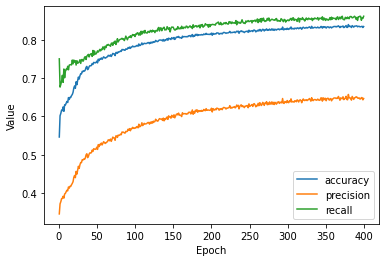

In [15]:
#@title Train the model on the training set.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 400
batch_size = 100
classification_threshold = 0.25
label_name = "target"

# Here is the updated definition of METRICS:
my_metrics = [
      tf.keras.metrics.BinaryAccuracy(threshold=classification_threshold,
                                      name='accuracy'
                                      ),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
      tf.keras.metrics.AUC(num_thresholds=100, name='auc')
]

my_feature_layer = define_feature_layer()
# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_num_norm:
my_feature_layer(dict(train_df))

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer, my_metrics)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)



In [16]:
#@title Evaluate test set

features = {name:np.array(value) for name, value in test_df.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

45/45 [==============================] - 1s 3ms/step - loss: 0.3895 - accuracy: 0.8026 - precision: 0.6007 - recall: 0.8058 - auc: 0.8791


[0.38947999477386475,
 0.8025933504104614,
 0.6007393598556519,
 0.8057851195335388,
 0.8790900111198425]